In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install geopandas
!pip install pygeos
!pip install shapely
!pip install pyproj

#Optional ones
!pip install pyogrio


# !pip install pyscopg2
# !pip install GeoAlchemy2
# !pip install geopy


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyogrio-0.3.0.tar.gz (322 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  Using cached pyogrio-0.2.0.tar.gz (332 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
ERROR: Could not find a version that satisfies the requirement pyogrio (from versions: 0.2.0, 0.3.0)
ERROR: 

In [2]:
# !pip uninstall rtree
# !brew install spatialindex
# !sudo apt install libspatialindex-dev
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# '''
# This script takes the watershed shapefiles generated from the hydrology script (and cleanred in qGIS) and, for each shape, 
# calculates the tree percentage and ecotype.
# '''

In [230]:
import os
import sys
import pandas as pd
import re
import geopandas as gpd
import numpy as np
import rtree
import re
# import pygeos
# gpd.options.use_pygeos = True

In [4]:
# #Set directory
# #Where did you save the the ''/1-StreamSurvey/' file? Add the path here
homepath = r'/content/drive/MyDrive'
data_folder= '/1-StreamSurvey'
homedir = homepath + data_folder 
# #This if the file that has the eFRI data with all the different land use types (WATER, etc)
fpath= '/6b-Watershed_Forest/' 
forest_file  = homedir + '/3-eFRI (Forest_Type)/3-AllForest_3161_boundingbox_catchoverlap.shp'
# #Insert the watershed file here 
watershdfile = homedir + '/6-CleanedCatchments/1-FixGeometries.shp'

eFri_col = ['layer_1', 'POLYID', 'POLYTYPE', 'OSPCOMP','USPCOMP', 'PRI_ECO', 'area', 'geometry']
for_waterpath = '0-WatershedMNRFileOverlap.shp'
landpath = '0-LandTypeOverlapNS.shp'
landCol= 'POLYTYPE'

In [77]:
def geoframeit(ipath):
    """Creates a geodataframe and assigns the 3161 coordinate reference system.

    Parameters
    ----------
    ipath : str
        The location of the shapefile 

    Returns
    -------
    geodataframe
        a geodataframe with the projection EPSG: 3161
    """
    geof= gpd.GeoDataFrame.from_file(ipath)
    geof.crs = {'proj': 'lcc','lat_1': 44.5,'lat_2': 53.5,'lat_0': 0,'lon_0': -85,'x_0': 930000,'y_0': 6430000,'datum': 'NAD83','units': 'm','no_defs': True}
    return geof

def to_geofile(f, finpath):
    """exports a geodataframe and assigns the 3161 coordinate reference system.

    Parameters
    ----------
    f: geodataframe 
        The geodataframe to be exported
    finpath : str
        The desired export location of the shapefile 
    """
    f.crs = {'proj': 'lcc','lat_1': 44.5,'lat_2': 53.5,'lat_0': 0,'lon_0': -85,'x_0': 930000,'y_0': 6430000,'datum': 'NAD83','units': 'm','no_defs': True}
    f.to_file(homedir + fpath + finpath)

def forwatint(catch, eFRI, eFri_col, output, typeCol):
    """Calculates the intesection area of the eFRI and generated catchment files. 
    Parameters
    ----------
    catchment : geodataframe
        The generated catchment shapefiles. 
    forestry: geodataframe
        The eFRI shapefile data.
    eFri_col: list
        The names of the eFRI features to be retained.
    output: str
        The directory for the intersection shapefile to be written to. 

    Returns
    -------
    for_water: geodataframe
        a geodataframe with the projection EPSG: 3161 including a column for the intersection_ID 
    typeCol: list
        Names of the unique values in the typelist specified
    intersect_area: str
        The name of the intersection area column 
    """
    # calculatingarea
    catch['area']= catch['geometry'].area
    # #Intersection of the forest type files and watersheds
    forest_water = gpd.overlay(catch, eFRI, how='intersection')
    forest_water.reset_index(inplace=True)
    # #Each invidvidual intersection will have an ID
    inname = 'Int_ID'
    forest_water.rename(columns= {'index': inname}, inplace=True)
    eFri_col.insert(0, inname)
    for_water= forest_water[eFri_col]
    # #Area of  intersection the forest type files and watersheds
    intersect_area = 'Int_Area'
    for_water['Int_Area']= forest_water['geometry'].area
    #to_geofile(for_water, output)
    typeCol= forest_water['POLYTYPE'].unique()
    return for_water, typeCol, intersect_area

def ReData(row, landCol, areaCol):
    """Makes the landtypes each a column header 
    Parameters
    ----------
    landcol : str
        The name of the column to be made headers. 
    areaCol: str
        The name of the column with the areas. 
    output: str
        The directory for the intersection shapefile to be written to. 

    Returns
    -------
    geodataframe
        a geodataframe with the projection EPSG: 3161 including a column for the intersection_ID 
    """

    row[row[landCol]]= row[areaCol]
    return row


In [37]:
watershed = geoframeit(watershdfile) # The catchments
forestry = geoframeit(forest_file) # The stands

In [275]:
#---FUNCTIONS TO PARSE OSP STRING INTO A DICT---

#Regex to match to tree type and tree type percentage; expecting strings of form 'Mr 10Bf 90' etc
treeTypeRegex = '([A-Z][a-z])'
# treeValueRegex = '[0-9]+'

#Takes in one of the above strings and returns a list of the tree types; e.g. 'Mr 10Bf 90' -> [Mr, Bf]
def getAllTreeTypes(ospcomp):
  types = []
  if pd.notnull(ospcomp):
    types.append(pd.Series(re.findall(treeTypeRegex, ospcomp)))
    # One concatenate is much faster than repeated appends or concatenations
    return pd.concat(types, ignore_index=True).unique()
  return types

#Takes in one of the above strings and returns a list of the tree values; e.g. 'Mr 10Bf 90' -> [10, 90]
def getAllTreeValues(ospcomp):
    vals = []
    # Remove whitespace from ospcomp string
    ospcompNoWhitespace = re.sub('[^\S\n\t]+', '', ospcomp)
    # Split string along letters
    ospCompSplit = re.split('\D', ospcompNoWhitespace)
    # Convert string to nums and drop empty strings
    for val in ospCompSplit:
      if val != "":
        vals.append(int(val))
    return vals

#Takes in one of the above strings and returns a dictionary of the tree types to values; e.g. 'Mr 10Bf 90' -> {'Mr': 10, 'Bf': 90}; returns empty dict if given None
def OSPCompStringToDict(OSPString):
  toReturn = dict()
  if OSPString == None: return toReturn
  treeTypes = getAllTreeTypes(OSPString)
  treeValues = getAllTreeValues(OSPString)
  for tType, tVal in zip(treeTypes, treeValues):
    toReturn[tType] = float(tVal)/100
  return toReturn

#Takes in all of the stand data as a data frame and returns all tree types across all data frames (without duplication) as a set
def getAllTreeTypesFromStandData(standData):
  toReturn = []
  for standIndex, stand in standData.iterrows():
    standTrees = list(getAllTreeTypes(stand['OSPCOMP']))
    toReturn = toReturn + standTrees
  return set(toReturn)

#---FUNCTIONS TO COMPUTE DICT OF PERCENTAGES FOR ONE CATCHMENT---

#Takes in a single catchment and a single stand and calculates the percent of the stand that is in the catchment
def getIntersectionAreaPercent(catchmentRow, standRow):
  catchmentPoly = catchmentRow['geometry']
  standPoly = standRow['geometry']
  intersectionPoly = catchmentPoly.intersection(standPoly)
  intersectionArea = intersectionPoly.area
  intersectionAreaPercent = intersectionArea/standRow['AREA']
  return intersectionAreaPercent

#Takes in a single stand (i.e. row from the stand dataframe) and returns a dict mapping tree types, primary eco-systems and polytypes to absolute areas; e.g. a dict of the form {'G054TtD n': 500, 'Bf': 400, 'Mr': 200, 'FOR': 500}
def getAreaBreakDownForStand(stand,intAreaPercent):
  toReturn = dict()
  area = stand['AREA']
  intersectionArea = area*intAreaPercent

  #Get overstory comp areas:
  treeBreakdown = OSPCompStringToDict(stand['OSPCOMP'])
  totalTreeArea = 0
  # print('treeBreakdown:', treeBreakdown)
  for treeType in treeBreakdown.keys():
    areaToAdd = intersectionArea*treeBreakdown[treeType]
    toReturn[treeType] = areaToAdd
    totalTreeArea += areaToAdd

  #Get pri-eco area
  priEco = stand['PRI_ECO']
  if priEco != None:
    toReturn[priEco] = intersectionArea

  #Get polytype area
  polyType = stand['POLYTYPE']
  if polyType != None:
    toReturn[polyType] = intersectionArea

  return toReturn

#Takes in a single catchment (i.e. row from the catchment dataframe) and returns a dict mapping tree types,
# primary eco-systems and polytypes to absolute areas by summing up these areas from stands times their overlap with the catchment
def getCatchmentBreakdownDic(catchment, standData):
  catchmentAreaBreakDown = dict()
  for standIndex, stand in standData.iterrows():
    intAreaPercent = getIntersectionAreaPercent(catchment, stand)
    if intAreaPercent > 0:
      standBreakdown = getAreaBreakDownForStand(stand, intAreaPercent)
      
      # Sum dictionaries together by keys
      catchmentAreaBreakDown = {k: catchmentAreaBreakDown.get(k, 0) + standBreakdown.get(k, 0) for k in set(catchmentAreaBreakDown) | set(standBreakdown)}

    #Normalize forest percentages so forest percentages sum to one
  return catchmentAreaBreakDown

#Takes in a single catchment (i.e. row from the catchment dataframe) and returns a dict mapping tree types, primary eco-systems 
# and polytypes to percentages of the catchment area; 
# NOTE: the normalizeForestPercentages determines whether the forest percentages are percentages of the total area of the catchment or percentages of the catchment designated FOR;
# if true all tree type percentages should sum to 100 +- rounding issues
def getCatchmentBreakdownDicPercentages(catchment, standData, normalizeForestPercentages):
  catchmentAreaBreakDown = getCatchmentBreakdownDic(catchment, standData)
  catchmentPercentilesBreakdown = {k: v / catchment['area'] for k, v in catchmentAreaBreakDown.items()}

  # Normalize forest percentages
  if normalizeForestPercentages:
    allTreeTypes = getAllTreeTypesFromStandData(standData)
    forestPercentage = catchmentPercentilesBreakdown['FOR']
    for treeType in allTreeTypes:
      if treeType in catchmentPercentilesBreakdown.keys():
        catchmentPercentilesBreakdown[treeType] = catchmentPercentilesBreakdown[treeType]/forestPercentage
  
  totalTreePercent = 0
  for treeType in allTreeTypes:
    if treeType in catchmentPercentilesBreakdown.keys():
      totalTreePercent += catchmentPercentilesBreakdown[treeType]

  return catchmentPercentilesBreakdown

#---MAIN FUNCTIONS---

#Takes in the catchments dataframe and a list of each catchments dictionary mapping tree types,
# polytype and primary ecosystems to percents and adds these as columns to the catchments dataframe
# (adds _per to the end of each key before adding to the dataframe)
def addColumnsFromAllCatchmentDicts(catchmentsDF, allCatchmentPercentileDicts):
  allkeys = set().union(*allCatchmentPercentileDicts)
  paddedOut = False
  for keyToAddAsColumn in allkeys:
    colToAdd = []

    for catchmentDict in allCatchmentPercentileDicts:
      if keyToAddAsColumn in catchmentDict:
        colToAdd.append(catchmentDict[keyToAddAsColumn])
      else:
        colToAdd.append(0) # If no entry just put in 0
    colName = keyToAddAsColumn + '_per'

    #PAD OUT COL TO ADD IF ONLY DOING SOME OF THE CATCHMENTS
    while len(colToAdd) < len(catchmentsDF.index):
      paddedOut = True 
      colToAdd.append(0)

    catchmentsDF[colName] = colToAdd

  if paddedOut: 
    print("WARNING: PADDING OUT COLUMN SO IT FITS IN THE DATAFRAME; SHOULD ONLY HAPPEN IF NOT COMPUTING FOR ALL CATCHMENTS")

#Takes in the catchments dataframe and stands dataframe and adds percentage breakdowns of tree types, polytypes and primary-ecosystem to the catchments dataframe
# numcatchments determines how many catchments to do this for; if it's -1 then will do all catchments
# normalizeForestPercentages determines whether the forest percentages are percentages of the total area of the catchment or percentages of the catchment designated FOR; if true all tree type percentages should sum to 100 +- rounding issues
def addCatchmentBreakdowns(catchments, standData, normalizeForestPercentages=True, numCatchments=-1):

  allCatchmentPercentileDicts = []
  i = 0
  for catchmentIndex, catchment in catchments.iterrows():
    catchmentPercentilesBreakdown = getCatchmentBreakdownDicPercentages(catchment, standData, normalizeForestPercentages)
    allCatchmentPercentileDicts.append(catchmentPercentilesBreakdown)
    print('Finished catchment', catchmentIndex, 'with percentage breakdowns:', catchmentPercentilesBreakdown)
    i+=1
    if i == numCatchments: break;
  addColumnsFromAllCatchmentDicts(catchments, allCatchmentPercentileDicts)

In [276]:
#Num catchments to compute breakdowns for; set to -1 to run on all catchments
numCatchments = -1

addCatchmentBreakdowns(watershed, forestry, numCatchments=numCatchments)
display(watershed)

Finished catchment 0 with percentage breakdowns: {'Mr': 0.08653227555834649, 'G054TtD n': 0.8615761120844995, 'Bf': 0.013259878451763376, 'Sw': 0.09979215401010984, 'G058TtD n': 0.00206946065761517, 'FOR': 0.9956702357879876, 'Pt': 0.013259878451763376, 'Pw': 0.17306455111669297, 'G070TtD n': 0.13202466304587296, 'By': 0.31284418647198303, 'Mh': 0.30124707593934086}
Finished catchment 1 with percentage breakdowns: {'G139S D n': 0.00833420446852972, 'G067TtD n': 4.4394861556450526e-05, 'G058TtD n': 0.6988992108871221, 'G042TtD n': 0.06108389138036688, 'FOR': 0.9869996685389901, 'G070TtD n': 0.015487219667231258, 'By': 0.21808329701913637, 'OMS': 0.00833420446852972, 'G129TtD n': 0.21148495174271342, 'Mr': 0.10411742385306698, 'Bf': 0.030609180996915696, 'Cw': 0.10713526989110583, 'Sw': 0.05204523089741962, 'Pt': 4.497961141381758e-06, 'Mh': 0.48800509938121406}
Finished catchment 2 with percentage breakdowns: {'Bw': 0.01749570015126521, 'G058TtD n': 0.7098247528543713, 'G197X': 0.001282

,FID,VALUE,layer,path,area,slope_medi,slope_stde,aspect_med,aspect_maj,stindex_me,...,G158S R n_per,G050TtMDn_per,TMS_per,G126TlD n_per,G101TtS n_per,G052TtD n_per,Pr_per,Bd_per,Ct_per,Pb_per
0,1,1.0,None,None,67793.53,8.879882,3.786613,155.970795,32.716076,5.763933,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0
1,1,1.0,1000.1wat_filt,/run/media/erika/maxone/1-StreamSurvey/5-Hydro...,668217.99,4.181822,3.080735,84.924034,0.033638,1.737190,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0
2,1,1.0,100.1wat_filt,/run/media/erika/maxone/1-StreamSurvey/5-Hydro...,339111.01,8.374226,5.031613,115.201424,0.531153,4.885279,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0
3,1,1.0,1010.1wat_filt,/run/media/erika/maxone/1-StreamSurvey/5-Hydro...,19337019.15,5.989441,5.118306,169.376160,171.499374,3.020738,...,0.0,0.0,0.000365,0.0,0.0,0.07520,0.000000,0.0,0.0,0.0
4,1,1.0,1020.1wat_filt,/run/media/erika/maxone/1-StreamSurvey/5-Hydro...,303840.63,5.207145,2.798463,241.777786,0.104344,2.768238,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,1,1.0,950.1wat_filt,/run/media/erika/maxone/1-StreamSurvey/5-Hydro...,80479.90,7.174245,2.663303,138.794571,78.224365,3.683579,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0
171,1,1.0,960.1wat_filt,/run/media/erika/maxone/1-StreamSurvey/5-Hydro...,242332.44,2.318186,2.003898,190.474030,98.234360,0.937228,...,0.0,0.0,0.000000,0.0,0.0,0.20703,0.048534,0.0,0.0,0.0
172,1,1.0,970.1wat_filt,/run/media/erika/maxone/1-StreamSurvey/5-Hydro...,94046.38,7.920053,5.910566,223.271538,191.097702,4.076676,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0
173,1,1.0,980.1wat_filt,/run/media/erika/maxone/1-StreamSurvey/5-Hydro...,221538.24,7.390445,3.087611,63.323505,3.157576,4.103713,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0


In [319]:
#CODE FOR SPOT CHECKING DATA
allTypes = list(forestry['PRI_ECO'].unique())
allTypes.remove(None)
print(allTypes)
# allTreeTypes = getAllTreeTypesFromStandData(forestry)

['G049TlD n', 'G052TtD n', 'G049TtD n', 'G058TtM n', 'G058TtD n', 'G055TtD n', 'G040TtM n', 'G065TtD n', 'G136TtD n', 'G016TtVSn', 'G050TtD n', 'G055TtM n', 'G048TtD n', 'G067TtD n', 'G070TtD n', 'G052TlD n', 'G054TtD n', 'G058TlM n', 'G058TlD n', 'G136TlD n', 'G035TtD n', 'G048TtM n', 'G129TtD n', 'G107TtD n', 'G042TtD n', 'G053TtD n', 'G051TtD n', 'G059TtD n', 'G114TtD n', 'G128TtD n', 'G066TtD n', 'G058TtMDn', 'G107TtMDn', 'G073TtD n', 'G042TtM n', 'G050TtM n', 'G107TtM n', 'G131TtD n', 'G069TtD n', 'G052TtM n', 'G051TtM n', 'G146S   n', 'G055TlD n', 'G139S D n', 'G142N   n', 'G065TlD n', 'G135S D n', 'U999', 'G099TtD n', 'G197X', 'G128TlD n', 'G223TtD n', 'G164S R n', 'G104TtD n', 'G140S D n', 'G101TtD n', 'U998', 'G098TtD n', 'G146N   n', 'G055TtMDn', 'G042TtMDn', 'G140N D n', 'G067TlD n', 'G046S D n', 'G122TtD n', 'G054TtM n', 'G139N D n', 'G104TtM n', 'G088TtD n', 'G033TtD n', 'G011TtVSn', 'G127TtD n', 'G097TtD n', 'G050TtS n', 'G064TtD n', 'G007X D n', 'G041TtD n', 'G036TtMDn',

[0.9956702357879876, 0.9953338730075199, 0.9952493137866566, 0.967831137846817, 0.987910578884371, 0.9952608785847975, 0.9927443557460756, 0.9927443557460756, 0.7449369298809574, 0.995251187352599, 0.9932074544756341, 0.995215544917613, 0.9952306185653683, 0.995230454921448, 0.9552159402197241, 0.9953102634740013, 0.9678615368086837, 0.9952740906648889, 0.9915942222404747, 0.9487067338061483, 0.9953349955762893, 0.9953302321253749, 0.9951961664487727, 0.9953317117407697, 0.977990466114309, 0.9800795334207959, 0.9953407681864802, 0.9701281305562577, 0.9303708552506694, 0.9510302157690348, 0.9952920307205074, 0.995290843950017, 0.9510987315355998, 0.9901585506926543, 0.9392519513686906, 0.9953092924685634, 0.9953168957669585, 0.9495588936353652, 0.9621872459525925, 0.9952788802601076, 0.995276592703761, 0.9139303413123215, 0.8119339198070907, 0.9750226731177546, 0.9952208946312759, 0.9953859408584388, 0.9953796154890465, 0.9953795842620105, 0.9953845000829711, 0.9058765919253432, 0.99536

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc1f0c2cbd0>]],
      dtype=object)

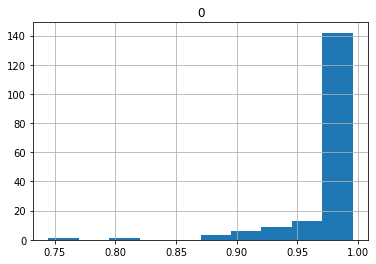

In [323]:
#CODE FOR SPOT CHECKING DATA
percents = []
for catchIndex in range(len(watershed)):
  percent = 0
  for currType in allTypes:
    # print('currType:', currType)
    currTypeString = currType +'_per'
    # print(currTypeString)
    if currTypeString in watershed.iloc[catchIndex].keys():
        val = watershed.iloc[catchIndex][currTypeString]
        percent += val
  percents.append(percent)


#  [sum([watershed.iloc[i][x+'_per'] for x in allTypes]) for i in range(len(watershed))]
print(percents)
percentsDF = pd.DataFrame(percents)
percentsDF.hist()

# watershed.iloc[85]['OMS_per']+watershed.iloc[85]['FOR_per']+watershed.iloc[85]['ISL_per']

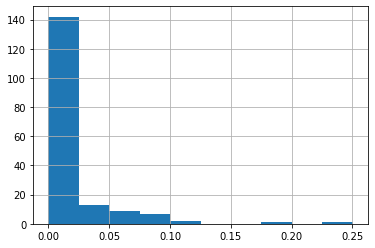

In [302]:
watershed['WAT_per'].hist()

In [280]:
#CODE FOR WRITING DATA TO FILE

fileName = "/watershedWithPercentages"
fileString = homepath + data_folder + fileName
watershed.to_csv(fileString, encoding='utf-8', index=False)